In [ ]:
import torch
import polyak


x = torch.randn(2, requires_grad=True, dtype=torch.double)
def loss_function():
    return sum(torch.abs(x))

def closure():
    optimizer.zero_grad()
    loss = loss_function()
    loss.backward()
    return loss

param = [x]
optimizer = polyak.Polyak(param)
# A short loop that applies the Polyak subgradient method to the loss function
for i in range(100):
    loss = optimizer.step(closure)
    print("Iteration: {}, Loss: {}".format(i, loss))
    print("x: {}".format(x.data))


In [ ]:
# Quick working test of superpolyak with numpy functions
import util
import numpy as np
import torch

def f(y):
    return np.sum(np.abs(y))

def gradf(y):
    return np.sign(y)

d = 5
max_elts = d
y0 = np.random.randn(d)
while f(y0) > 1e-20:
    y, d = util.build_bundle(f=f, gradf=gradf, y0=y0, tau=1.,eta_est=1.5,min_f=0., max_elts=max_elts)
    y0 = y
    print("f(y)", f(y0))

In [ ]:
# A pytorch compatible version of the above code.
import util
import numpy as np
import torch

d = 5
max_elts = d
x = torch.randn(d, requires_grad=True, dtype=torch.double)

def f():
    return torch.sum(abs(x))

# Closure function to allow us to call backward.
def closure():
    if x.grad is None:
        x.grad = torch.zeros_like(x)
    else:
        x.grad.data.zero_()
    loss = f()
    loss.backward()
    return loss

current_iter = 0
while closure().item() > 1e-20 and current_iter < 100:
    y, bundle_idx = util.build_bundle_torch(closure, x=x, tau=np.inf,eta_est=1.5,min_f=0., max_elts=max_elts)
    x.data = torch.Tensor(y)
    print("f(y)", closure().item())
    print("Bundle index", bundle_idx)
    current_iter += 1

In [ ]:
# A version of the previous code that supports parameter groups.
import numpy as np
import torch
import torch.nn.functional as F

d = 5
max_elts = d
x = torch.randn(d, requires_grad=True, dtype=torch.double)

def f():
    return torch.sum(torch.abs(x))


# Closure function to allow us to call backward.
def closure():
    if x.grad is None:
        x.grad = torch.zeros_like(x)
    else:
        x.grad.data.zero_()
    loss = f()
    loss.backward()
    return loss

current_iter = 0
while closure().item() > 1e-20 and current_iter < 100:
    _, bundle_idx = util.build_bundle_torch_param_groups(closure, params=[x], tau=np.inf,eta_est=1.5,min_f=0., max_elts=max_elts)
    # x.data = torch.Tensor(y)
    print("f(y)", closure().item())
    print("Bundle index", bundle_idx)
    current_iter += 1

number of parameters 801
bundle size 100
Iteration:  0 , Loss:  0.009525892725535667 , Bundle_exit_step  100
Bundle index 100
Iteration:  100 , Loss:  0.00014558895038545294 , Bundle_exit_step  100
Bundle index 100
Iteration:  200 , Loss:  8.085626757026176e-08 , Bundle_exit_step  100
Bundle index 100
Iteration:  300 , Loss:  6.386557949156213e-14 , Bundle_exit_step  100
Bundle index 100
Iteration:  400 , Loss:  1.329492071988625e-14 , Bundle_exit_step  100
Bundle index 100
Iteration:  500 , Loss:  1.554312234475219e-14 , Bundle_exit_step  100
Bundle index 100
Iteration:  600 , Loss:  1.3614109839465982e-14 , Bundle_exit_step  100
Bundle index 100
Iteration:  700 , Loss:  1.1948775302528247e-14 , Bundle_exit_step  100
Bundle index 100
Iteration:  800 , Loss:  1.304512053934559e-14 , Bundle_exit_step  100
Bundle index 100
Iteration:  900 , Loss:  1.2795320358804929e-14 , Bundle_exit_step  100
Bundle index 100
Sucess


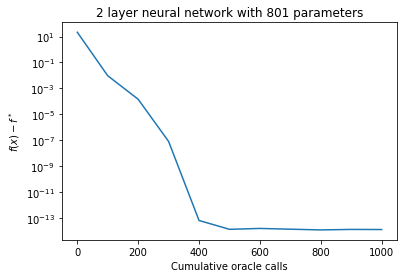

In [17]:
# Fitting a small neural network with pytorch.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import util

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 200, dtype=torch.double)
        self.fc2 = nn.Linear(200, 1, dtype=torch.double)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
# Let d be the number of parameters in net
d = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("number of parameters", d)
max_elts = int(100)
print("bundle size", max_elts)

# fake training data
x = torch.randn(100, 2, dtype=torch.double)
y = net(x).detach().clone().requires_grad_(False)
# Reset the parameters
net = Net()

# a loss function
def loss_function():
    return sum(torch.abs(net(x) - y))

# a closure function to allow us to call backward
def closure():
    net.zero_grad()
    loss = loss_function()
    loss.backward()
    return loss

max_oracle_calls = 1000
params = list(net.parameters())
gap = [closure().item()]
cumulative_oracle_calls = [0]
while closure().item() > 1e-16 and cumulative_oracle_calls[-1] < max_oracle_calls:
    _, bundle_idx = util.build_bundle_torch_param_groups(closure, params=params, tau=np.inf,eta_est=.9,min_f=0., max_elts=max_elts)
    print("Iteration: ", cumulative_oracle_calls[-1], ", Loss: ", closure().item(), ", Bundle_exit_step ", bundle_idx)
    print("Bundle index", bundle_idx)
    cumulative_oracle_calls.append(bundle_idx + cumulative_oracle_calls[-1])
    gap.append(closure().item())
print("Sucess")

# A matplotlib semilogylog plot of the gap between the loss.
# the x axes is the cumulative oracle calls
# the y axes is the loss
import matplotlib.pyplot as plt
plt.semilogy(cumulative_oracle_calls, gap)
# label the x axes cumulative oracle calls
# label the y axes the $f(x) - f^*$ gap
plt.xlabel("Cumulative oracle calls")
plt.ylabel("$f(x) - f^*$")
# title the plot: 2 layer neural network with d parameters, where d is replaced by its numerical value
plt.title("2 layer neural network with {} parameters".format(d))
plt.show()
